# Preprocessing Script

This script prepares the dataset for **model training and forecasting** by detecting, removing, and filling missing values, while adding temporal features for improved modeling.

### Key Steps

1. **Load and Prepare Data**
   - Read `X_table.csv`, set timestamps as index, and remove unused variables.
   - Add **calendar** and **cyclical** time features (hour, day, sin/cos encodings).
   - Split into **training/validation** and **test** periods.

2. **Handle Missing Data**
   - Detect and remove gaps longer than 6 hours in weather and price data.
   - Apply **linear interpolation** for shorter gaps (≤6 hours).
   - Visualize missingness before and after cleaning.

3. **Fill Missing Power Values**
   - Train an **XGBoost regressor** on the training set using time-series cross-validation.
   - Predict and fill missing `power` values, avoiding data leakage.
   - Check feature importance and RMSE performance.

4. **Finalize and Export**
   - Drop remaining missing values in the test set.
   - Export cleaned datasets:
     - `final_data_train.csv`
     - `final_data_test.csv`
   - Generate heatmaps and prediction plots for final verification.

**Output:** A fully cleaned, gap-free dataset with temporal features, ready for rolling-origin validation and forecasting.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

**Reading the data and adding Temporal features** <br>
Here we remove the imbalance price as its missing for most of the period we have and the price area as we only looked at prices in the same area.

In [2]:
df = pd.read_csv('data/ProcessedData/X_table.csv')
#Since there is no timestamp missing in X_table, make Timestamp the index
df["ts"] = pd.to_datetime(df["ts"])
df = df.set_index("ts").sort_index()

#Drop Imbalance&PA
df = df.drop(['ImbalanceMWh', 'PriceArea'], axis=1)


# Calendar features
df["year"]       = df.index.year
df["month"]      = df.index.month
df["day"]        = df.index.day
df["hour"]       = df.index.hour
df["dayofweek"]  = df.index.dayofweek
df["dayofyear"]  = df.index.dayofyear

# Cyclical encodings
df["hour_sin"] = np.sin(2 * np.pi * df.index.hour / 24)
df["hour_cos"] = np.cos(2 * np.pi * df.index.hour / 24)
df["dow_sin"]  = np.sin(2 * np.pi * df.index.dayofweek / 7)
df["dow_cos"]  = np.cos(2 * np.pi * df.index.dayofweek / 7)


TRAIN_VALIDATION_START = pd.to_datetime("2021-01-01 00:00:00")
TRAIN_VALIDATION_END   = pd.to_datetime("2023-08-14 23:00:00")
TEST_START             = pd.to_datetime("2023-08-15 00:00:00")
TEST_END               = pd.to_datetime("2024-08-14 23:00:00")

# Split using index-based selection
train_validation_df = df.loc[TRAIN_VALIDATION_START:TRAIN_VALIDATION_END].copy()
test_df = df.loc[TEST_START:TEST_END].copy()


**Interpolation of values** <br>
Here we find all the gaps of values longer than 6hours in the weather data, and remove the corresponding rows before we interpolate.

In [3]:
def long_nan_run_mask(s: pd.Series, min_len=6, include_edges=True) -> pd.Series:
    """
    True for rows that are NaN AND belong to a NaN run whose length >= min_len.
    """
    nanmask = s.isna()
    if not nanmask.any():
        return pd.Series(False, index=s.index)

    groups = (nanmask != nanmask.shift(fill_value=False)).cumsum()
    run_size = nanmask.groupby(groups).transform('sum')   # length for each row's run
    long = nanmask & (run_size >= min_len)

    if not include_edges:
        first_gid, last_gid = groups.iloc[0], groups.iloc[-1]
        if nanmask.iloc[0]:  # leading NaN run
            long = long & (groups != first_gid)
        if nanmask.iloc[-1]: # trailing NaN run
            long = long & (groups != last_gid)

    return long

#Find missing values only in these columns
#cols = train_validation_df.loc[:, 'mean_IGR_Nex':'mean_wind_dir_Hammer_ Odde_Fyr'].columns
cols = list(train_validation_df.loc[:, 'mean_IGR_Nex':'mean_wind_dir_Hammer_ Odde_Fyr'].columns) \
       + ['ImbalancePriceDKK', 'BalancingPowerPriceUpDKK', 'BalancingPowerPriceDownDKK']

any_long_gap_train = pd.DataFrame({c: long_nan_run_mask(df[c], min_len=6, include_edges=True) for c in cols}).any(axis=1)
# Keep only rows without long gaps in any selected column
Train_large_removed = train_validation_df.loc[~any_long_gap_train].copy()

any_long_gap_test = pd.DataFrame({c: long_nan_run_mask(df[c], min_len=6, include_edges=True) for c in cols}).any(axis=1)
Test_large_removed = test_df.loc[~any_long_gap_test].copy()

**Interpolation of missing values, for gaps shorter than 6**<br>
Here there should only be missing intervals 6 or shorter.

In [4]:
def interpolate_limited(df_in, columns, max_gap):
    df_out = df_in.copy()  # avoid mutating caller unless you want to
    for col in columns:
        df_out[col] = df_out[col].interpolate(
            method="linear",
            limit=max_gap,            # fill runs of NaNs of length <= max_gap
            limit_direction="forward",   # search both forward/backward within runs
            limit_area="inside"       # don't fill NaNs at the edges
        )
    return df_out

# Example: only fill gaps ≤ 6 for temperature, wind_speed
cols = list(Train_large_removed.loc[:, 'mean_IGR_Nex':'mean_wind_dir_Hammer_ Odde_Fyr'].columns) \
       + ['ImbalancePriceDKK', 'BalancingPowerPriceUpDKK', 'BalancingPowerPriceDownDKK']
#Interpolated_test = interpolate_limited(df_clean, columns = df_clean.loc[:,'mean_IGR_Nex':'mean_wind_dir_Hammer_ Odde_Fyr'].columns, max_gap=6)
Interpolated_train = interpolate_limited(Train_large_removed, columns = cols, max_gap=6)
Interpolated_test = interpolate_limited(Test_large_removed, columns = cols, max_gap=6)


Functions for analysing the removed values and make sure there is no missing...

In [5]:
def gap_lengths(s: pd.Series) -> pd.Series:
    """Return lengths of all NaN runs in s (one length per gap)."""
    mask = s.isna()
    if not mask.any():
        return pd.Series(dtype=int)
    groups = (mask != mask.shift(fill_value=False)).cumsum()
    run_sizes = mask.groupby(groups).sum()                # sizes of runs (True counts)
    is_nan_group = mask.groupby(groups).first()           # which runs are NaN runs
    return run_sizes[is_nan_group].astype(int)


def count_gaps_lt6(df: pd.DataFrame, columns=None, hours=6) -> pd.Series:
    """Per column, count gaps with length < hours (hours==#rows since hourly)."""
    if columns is None:
        columns = df.columns
    return pd.Series({col: (gap_lengths(df[col]) < hours).sum() for col in columns})

# Example usage:
counts_per_col = count_gaps_lt6(Train_large_removed, columns=['mean_IGR_Nex'], hours=6)
#counts_per_col_2 = count_gaps_lt6(df_clean_test, columns=['mean_IGR_Nex'], hours=6)
# For a single overall count across selected columns:
total_short_gaps = int(counts_per_col.sum())

391 missing values removed in mean IGR_Nex 

In [6]:
print(sum(Train_large_removed.loc[:,'mean_IGR_Nex'].isna()))
sum(Interpolated_train.loc[:,'mean_IGR_Nex'].isna())

391


0

Checking which values were interpolated and to what value

In [7]:
# Define the column range you interpolated (use the exact end label)

col = 'mean_IGR_Nex'
before_col = Train_large_removed[col].copy()          # Series (before)
after_col  = Interpolated_train[col].copy()

filled_mask_col = before_col.isna() & after_col.notna()
filled_count    = int(filled_mask_col.sum())
remaining_count = int(after_col.isna().sum()) # Series (after)

print(f"Filled: {filled_count}, Remaining NaNs: {remaining_count}")
print(after_col[filled_mask_col])     # preview of new values
print(before_col.compare(after_col, keep_equal=False))  # NaN -> value

Filled: 391, Remaining NaNs: 0
ts
2021-01-18 16:00:00      8.5
2021-01-21 19:00:00      0.0
2021-02-16 13:00:00     59.0
2021-03-01 21:00:00      0.0
2021-04-19 10:00:00    596.5
                       ...  
2023-07-29 06:00:00    250.5
2023-07-31 04:00:00     29.0
2023-07-31 09:00:00    357.0
2023-08-02 09:00:00    300.0
2023-08-03 13:00:00    395.5
Name: mean_IGR_Nex, Length: 391, dtype: float64
                     self  other
ts                              
2021-01-18 16:00:00   NaN    8.5
2021-01-21 19:00:00   NaN    0.0
2021-02-16 13:00:00   NaN   59.0
2021-03-01 21:00:00   NaN    0.0
2021-04-19 10:00:00   NaN  596.5
...                   ...    ...
2023-07-29 06:00:00   NaN  250.5
2023-07-31 04:00:00   NaN   29.0
2023-07-31 09:00:00   NaN  357.0
2023-08-02 09:00:00   NaN  300.0
2023-08-03 13:00:00   NaN  395.5

[391 rows x 2 columns]


**Missing value heatmap**

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_missing_heatmap(df, title="Missing Data Visualization (Green: Available, Red: Missing)"):
    # Ensure datetime index (if possible)
    if not np.issubdtype(df.index.dtype, np.datetime64):
        try:
            df = df.copy()
            df.index = pd.to_datetime(df.index)
        except Exception:
            pass  # continue with whatever the index is

    # Boolean mask: True -> missing, False -> present
    miss = df.isna()

    # imshow needs numeric (0/1); transpose so rows=columns, cols=time
    data = miss.to_numpy(dtype=int).T  # shape: (n_cols, n_rows)

    # Colormap: 0 -> present (green), 1 -> missing (red)
    cmap = ListedColormap(["#1f7a1f", "#cc2b2b"])

    fig, ax = plt.subplots(figsize=(14, 7))
    im = ax.imshow(data, aspect="auto", interpolation="nearest", cmap=cmap)

    # Y ticks = column names
    ax.set_yticks(np.arange(len(df.columns)))
    ax.set_yticklabels(df.columns)

    # X ticks = time (sparse for readability)
    n = len(df.index)
    if n > 12:
        step = max(1, n // 12)
        xticks = np.arange(0, n, step)
    else:
        xticks = np.arange(n)
    ax.set_xticks(xticks)
    ax.set_xticklabels([str(df.index[i].date()) if hasattr(df.index[i], "date") else str(df.index[i]) for i in xticks],
                       rotation=45, ha="right")

    ax.set_xlabel("Time")
    ax.set_ylabel("Column")
    ax.set_title(title)
    # Build a tiny legend
    from matplotlib.patches import Patch
    legend_handles = [Patch(color="#1f7a1f", label="Available"),
                      Patch(color="#cc2b2b", label="Missing")]
    ax.legend(handles=legend_handles, loc="upper right")

    plt.tight_layout()
    plt.show()


**Filling missing Power values in training set using XGBoost**<br>
Here we fill the missing values in Power using xgboost, we only use data from the training set, nothing from the test set as to avoid data leakage. <br>
We do not use the interpolated values to train the model, avoid the compounding of errors there.


In [9]:
xgb = XGBRegressor(
    #objective="binary:logistic",  # or "multi:softprob" for multi-class
    #eval_metric="logloss",
    #use_label_encoder=False,
    #n_jobs=-1,
    tree_method="hist"
)


param_grid = {
    "n_estimators": [530, 550],
    "max_depth": [4,5,6],
    "learning_rate": [0.01],
    "subsample": [0.6, 0.5],
    "colsample_bytree": [0.8, 0.9],
}

drop_cols = [
    "DK2_DKK",
    "SYSTEM_DKK",
    "ImbalancePriceDKK",
    "BalancingPowerPriceUpDKK",
    "BalancingPowerPriceDownDKK",
]



powerforecast_x = train_validation_df.iloc[:,1:]
powerforecast_y = train_validation_df.iloc[:,0]

mask_known = powerforecast_y.notna()
X_known = powerforecast_x[mask_known]
y_known = powerforecast_y[mask_known]



tscv = TimeSeriesSplit(n_splits=5, test_size=None, gap=0)
grid_search = GridSearchCV(xgb, param_grid, cv=tscv, scoring='neg_mean_squared_error') 
grid_search.fit(X_known,y_known)


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'colsample_bytree': [0.8, 0.9],
                         'learning_rate': [0.01], 'max_depth': [4, 5, 6],
                         'n_estimators': [530, 550], 'subsample': [0.6, 0.5]},
             scoring='neg_mean_squared_error')

Here we have the most important features for the model.

In [10]:
best_model = grid_search.best_estimator_   # XGBRegressor

# Try to get feature names from the model; fall back to your training DataFrame
feat_names = None
for attr in ("feature_names_in_",):  # sklearn-style attr (often present)
    if hasattr(best_model, attr):
        feat_names = getattr(best_model, attr)
        break
if feat_names is None:
    feat_names = powerforecast_x.columns  # fallback if you trained on this DF

imp = best_model.feature_importances_  # array aligned to input feature order
imp_df = pd.DataFrame({"feature": feat_names, "importance": imp}) \
           .sort_values("importance", ascending=False)
print(imp_df.head(20))


                             feature  importance
12               mean_wind_speed_Nex    0.447158
13  mean_wind_speed_Hammer_ Odde_Fyr    0.090106
16                           DK2_DKK    0.038049
14                 mean_wind_dir_Nex    0.028512
20        BalancingPowerPriceDownDKK    0.028502
19          BalancingPowerPriceUpDKK    0.028192
8                       mean_hum_Nex    0.026621
15    mean_wind_dir_Hammer_ Odde_Fyr    0.022144
0                       mean_IGR_Nex    0.021771
18                 ImbalancePriceDKK    0.019011
6                       min_temp_Nex    0.017787
17                        SYSTEM_DKK    0.017069
26                         dayofyear    0.016654
4                      mean_temp_Nex    0.015751
10                          prec_Nex    0.014289
7           min_temp_Hammer_Odde_Fyr    0.013651
5          mean_temp_Hammer_Odde_Fyr    0.013584
3           max_temp_Hammer_Odde_Fyr    0.013336
25                         dayofweek    0.012813
22                  

**A look at one of the predicted power windows**

RMSE (first 1000, known targets): 0.2950


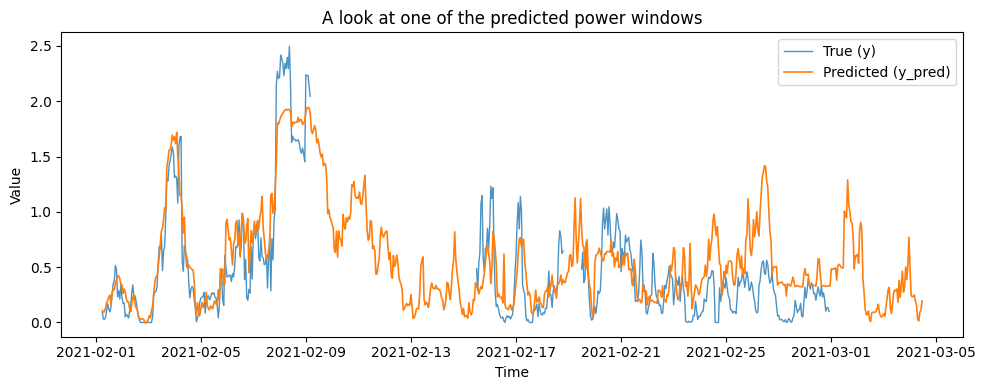

In [11]:
# masks
mask_missing = powerforecast_y.isna()
mask_known   = ~mask_missing

# predictions for the missing rows
X_missing = powerforecast_x.loc[mask_missing]
y_pred = grid_search.predict(powerforecast_x)  # or best_model.predict(...)


# Predict (if not already done)
y_pred = grid_search.predict(powerforecast_x)
y_pred = pd.Series(y_pred, index=powerforecast_x.index, name="y_pred")

# Align and slice first 1000
plot_df = pd.DataFrame({"y_true": powerforecast_y, "y_pred": y_pred}).sort_index().iloc[750:1500]

# Optional: RMSE on known targets within first 1000
mask_known = plot_df["y_true"].notna()
if mask_known.any():
    rmse_1k = np.sqrt(mean_squared_error(plot_df.loc[mask_known, "y_true"],
                                         plot_df.loc[mask_known, "y_pred"]))
    print(f"RMSE (first 1000, known targets): {rmse_1k:.4f}")

# Plot
plt.figure(figsize=(10,4))
plt.plot(plot_df.index, plot_df["y_true"], label="True (y)", linewidth=1.0, alpha=0.8)
plt.plot(plot_df.index, plot_df["y_pred"], label="Predicted (y_pred)", linewidth=1.2)
plt.title("A look at one of the predicted power windows")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()



In [12]:
cv_rmse_mean = np.sqrt(-grid_search.best_score_)  # mean RMSE across CV folds for best params
print("Mean CV RMSE:", cv_rmse_mean)

best_model = grid_search.best_estimator_
rmse_test = np.sqrt(mean_squared_error(y_known, best_model.predict(X_known)))
print("Fit RMSE:", rmse_test)


Mean CV RMSE: 0.3239574959226886
Fit RMSE: 0.25357810987662666


**Best CV RMSE : 0.3239** For xgboost

**Fill in missing values in Power** <br>
Here we use our predicted power values to fill in the missing gaps

In [13]:
import pandas as pd

# 0) Work on a copy
final_data_train = Interpolated_train.copy()

# 1) Ensure we have the 'power' column
if "power" not in final_data_train.columns:
    raise KeyError("Column 'power' not found in Interpolated_test")

# 2) Make sure indexes are datetime (helps prevent mismatch); skip if already datetime
final_data_train.index = pd.to_datetime(final_data_train.index, errors="ignore")

# 3) Turn y_pred into a Series with the *prediction timestamps* as index
#    -> If y_pred is already a pandas Series with the correct index, this will just keep it.
#    -> Otherwise, replace `pred_index` with the index you used to generate y_pred
#       (e.g., the features df you predicted on: pred_index = pred_features_df.index).
if isinstance(y_pred, pd.Series):
    y_pred_s = y_pred.copy()
else:
    # <<< SET THIS if y_pred is a numpy array >>>
    # pred_index = pred_features_df.index
    # y_pred_s = pd.Series(y_pred, index=pred_index, name="y_pred")
    raise ValueError("y_pred is not a Series. Convert it to a Series with the prediction timestamps as index.")

# Align types for index (datetime vs string)
y_pred_s.index = pd.to_datetime(y_pred_s.index, errors="ignore")

# 4) Find rows in final_data with missing 'power'
mask_missing = final_data_train["power"].isna()

# 5) Match timestamps: fill only where both datasets have the same index
to_fill_idx = final_data_train.index[mask_missing].intersection(y_pred_s.index)

# 6) Assign predictions into the NaN spots (others remain unchanged)
final_data_train.loc[to_fill_idx, "power"] = y_pred_s.loc[to_fill_idx]

# 7) Quick report
filled = len(to_fill_idx)
remaining_nans = int(final_data_train["power"].isna().sum())
print(f"Filled {filled} rows. Remaining NaNs in 'power': {remaining_nans}")

Filled 3831 rows. Remaining NaNs in 'power': 0


/var/folders/v4/lzkm2zzd3gb0q8rqggx5drch0000gn/T/ipykernel_38656/772347878.py:11: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  final_data_train.index = pd.to_datetime(final_data_train.index, errors="ignore")
/var/folders/v4/lzkm2zzd3gb0q8rqggx5drch0000gn/T/ipykernel_38656/772347878.py:26: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  y_pred_s.index = pd.to_datetime(y_pred_s.index, errors="ignore")


In [14]:
if final_data_train.isna().sum().sum() == 0:
    print("✅ No NaN values in the dataset!")
else:
    print("⚠️ There are still some NaN values in the dataset.")

✅ No NaN values in the dataset!


**Drop the NaN's in our Test set**

In [15]:
final_data_test = Interpolated_test.dropna(subset=['power']).copy()

**Making the csv files**

In [16]:
final_data_train.to_csv("data/final_data_train.csv", index=True) 
final_data_test.to_csv("data/final_data_test.csv", index=True) 

**Here we can se the training data changing through the code** 

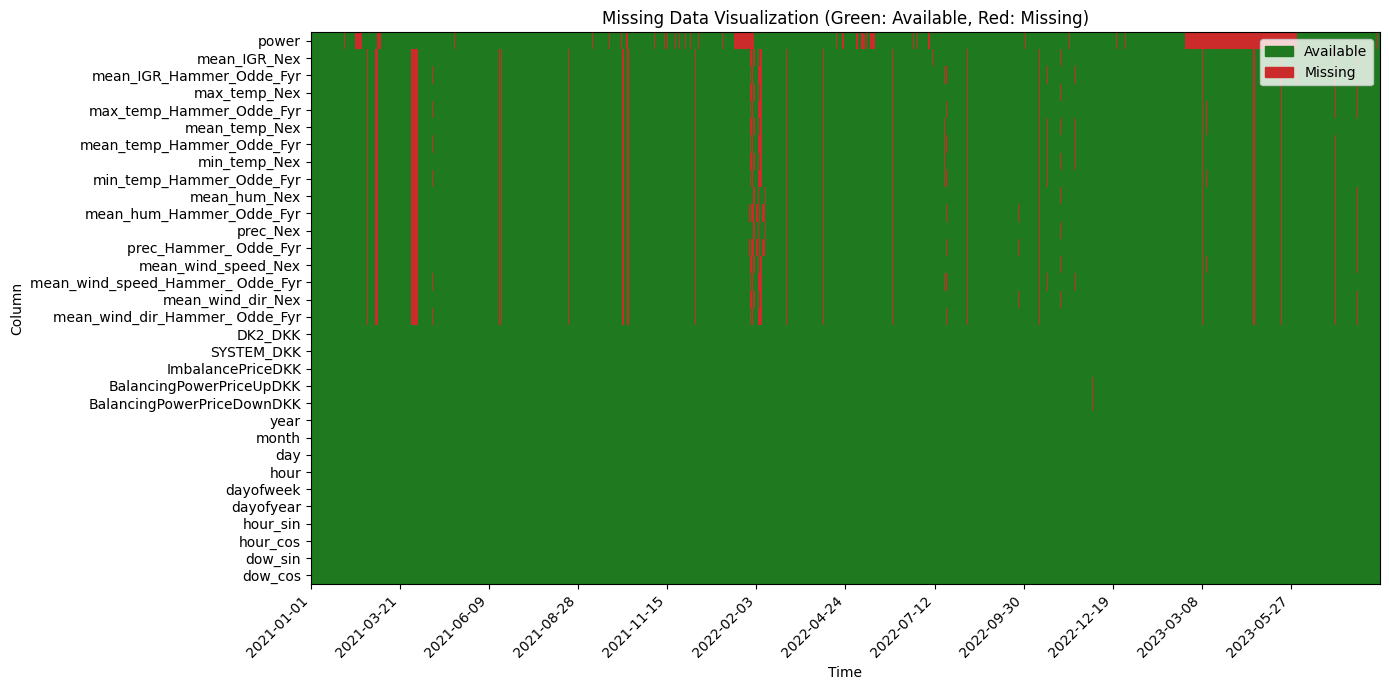

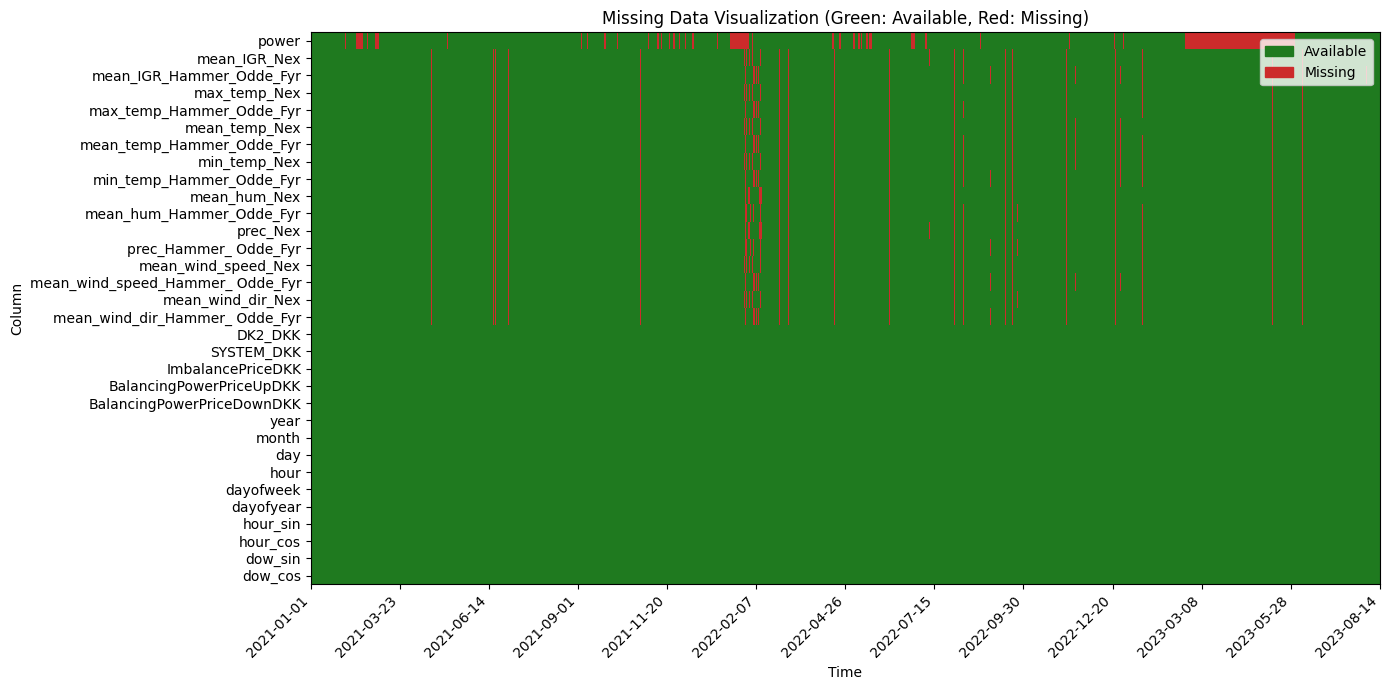

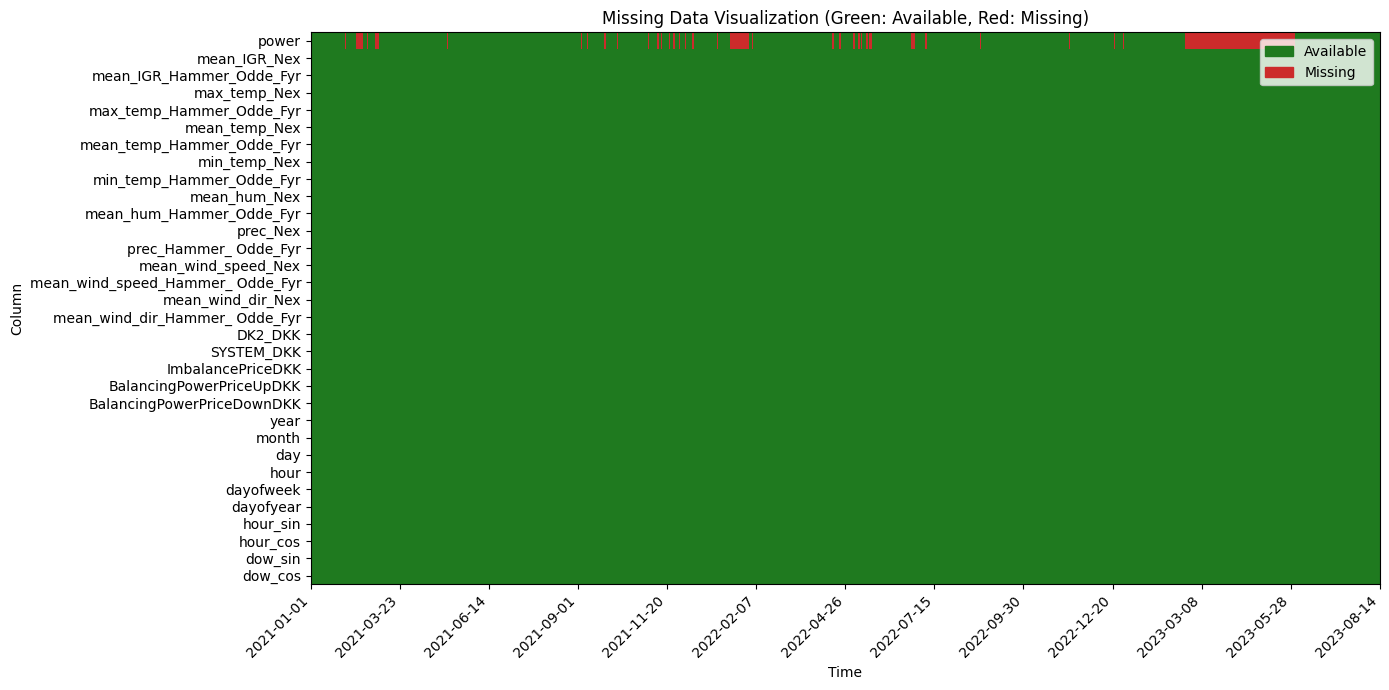

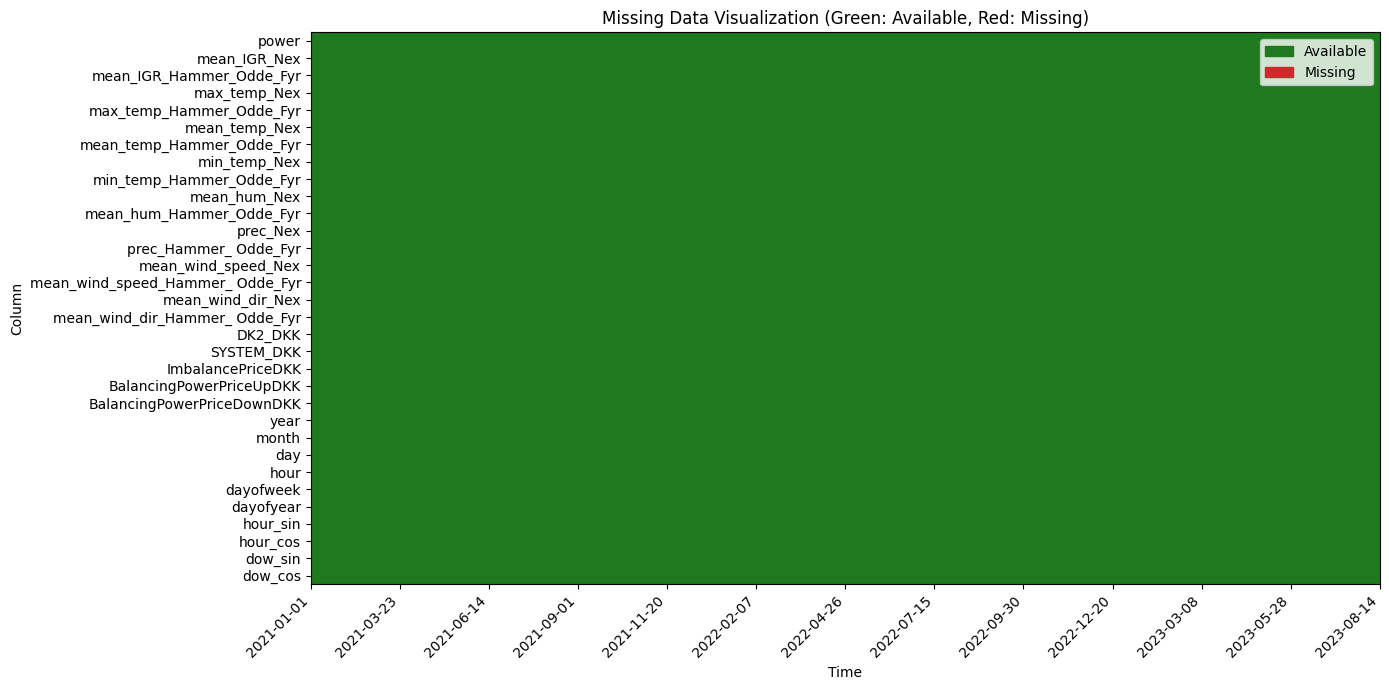

In [17]:
plot_missing_heatmap(train_validation_df) 
plot_missing_heatmap(Train_large_removed)
plot_missing_heatmap(Interpolated_train)
plot_missing_heatmap(final_data_train)

**And the same for the Test data**

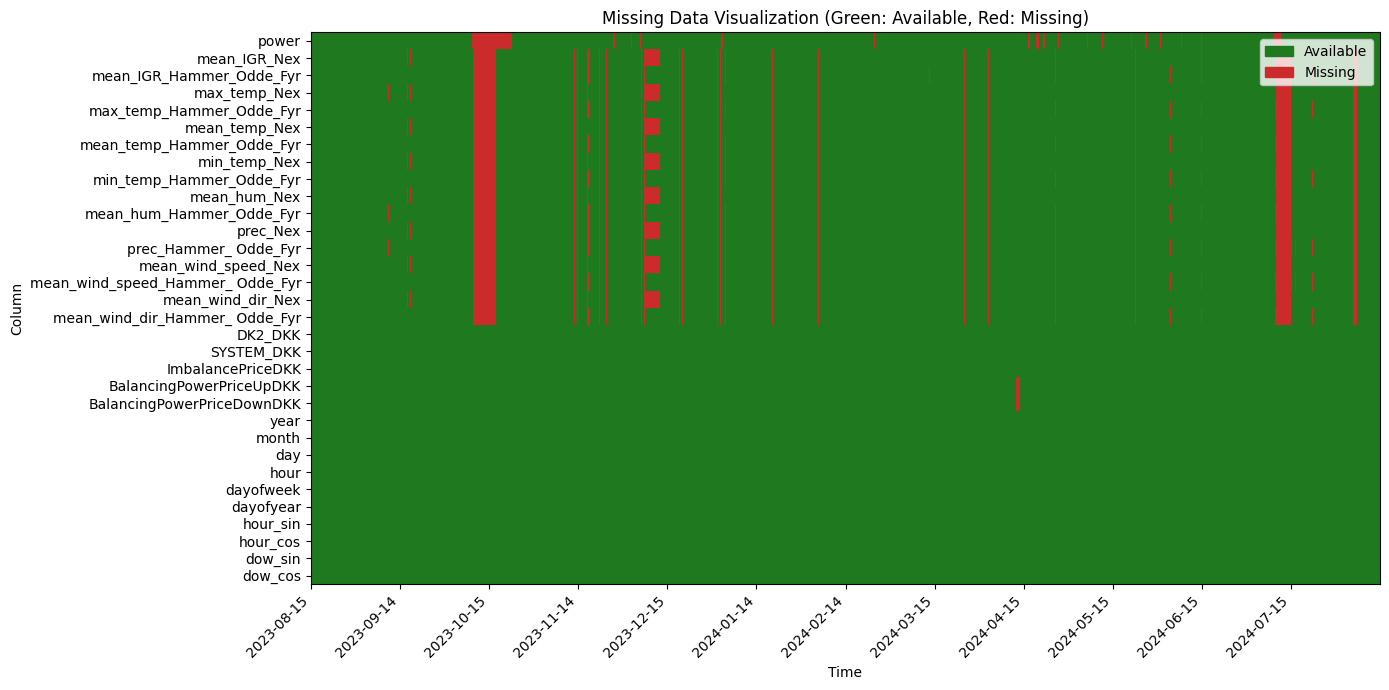

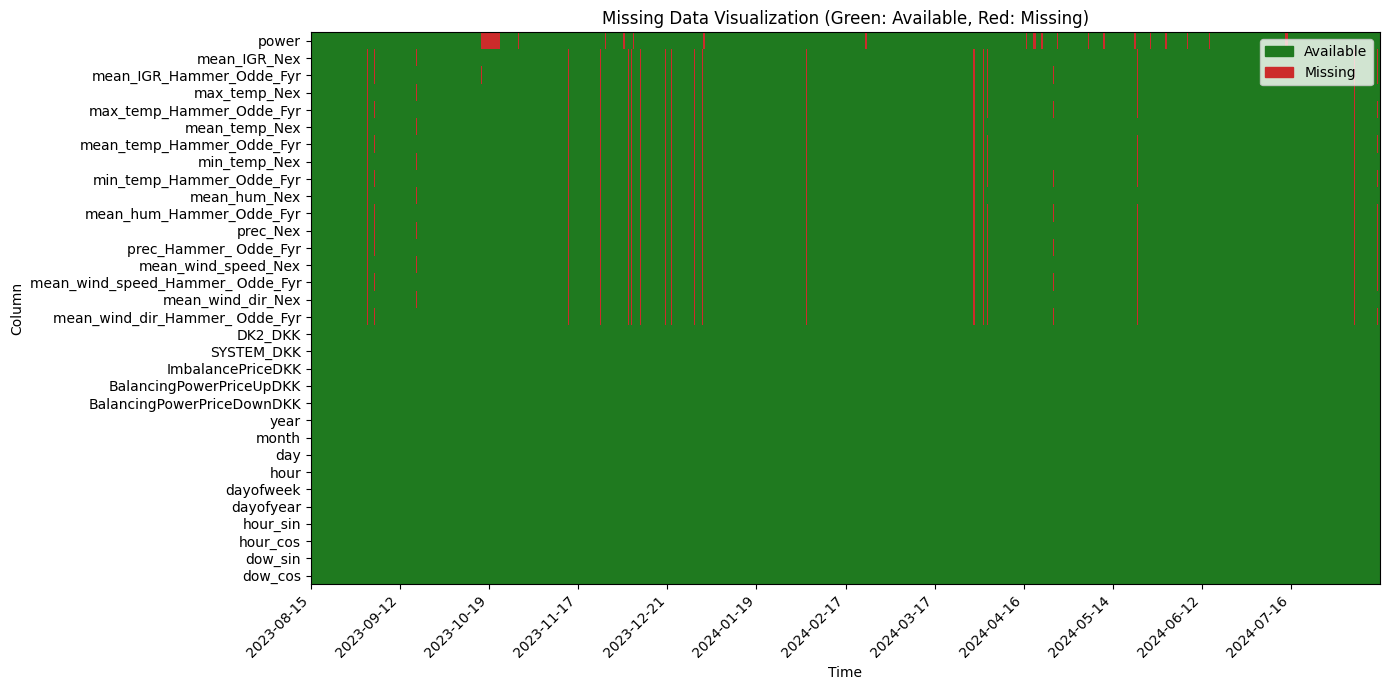

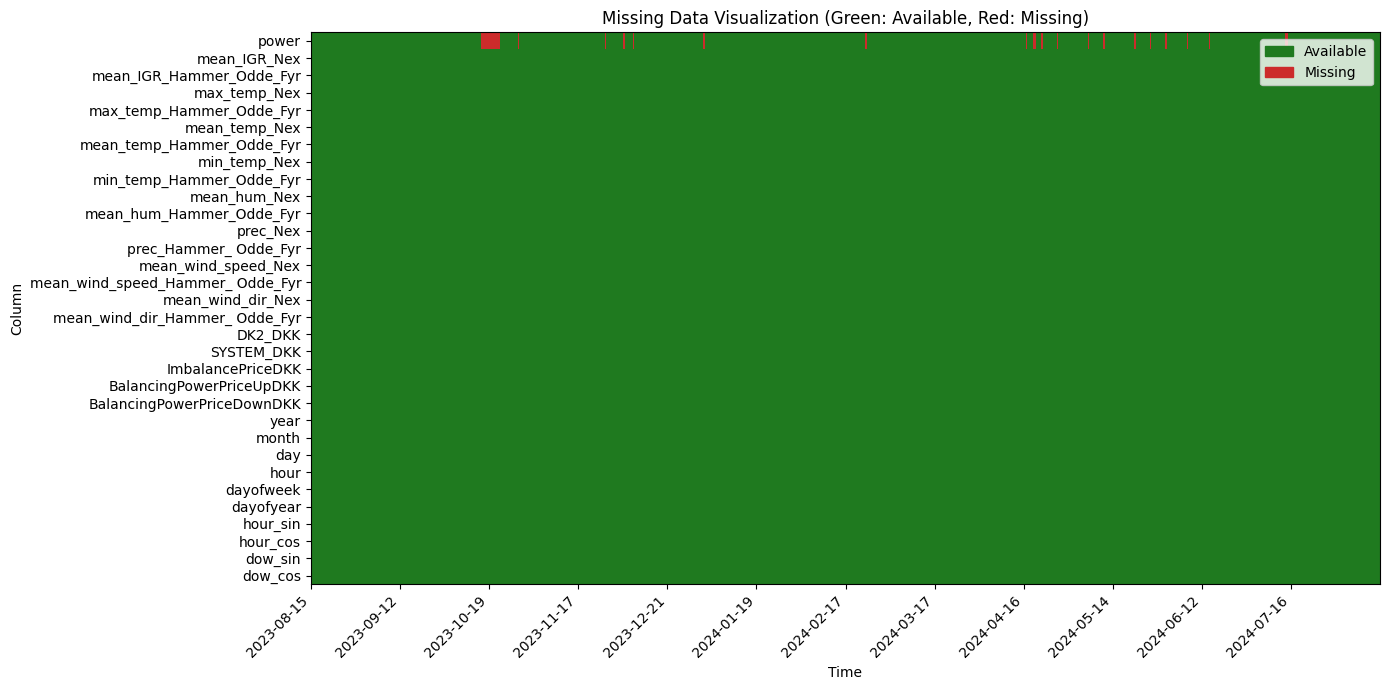

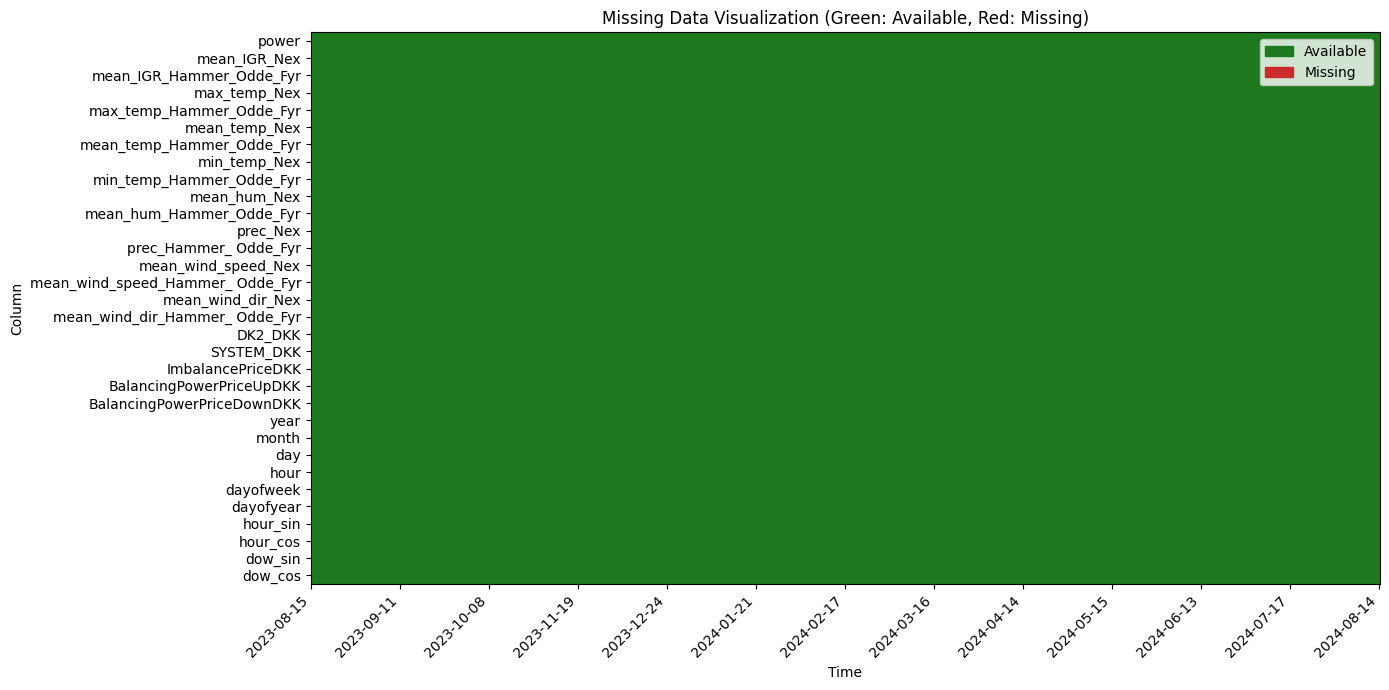

In [18]:
plot_missing_heatmap(test_df) 
plot_missing_heatmap(Test_large_removed)
plot_missing_heatmap(Interpolated_test)
plot_missing_heatmap(final_data_test)

**Extra visual confirmation** Plotting the whole training data - predicted values vs actual.


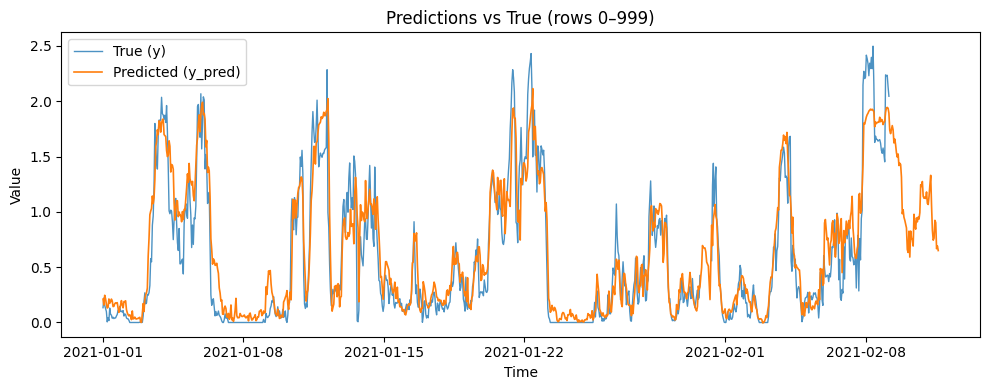

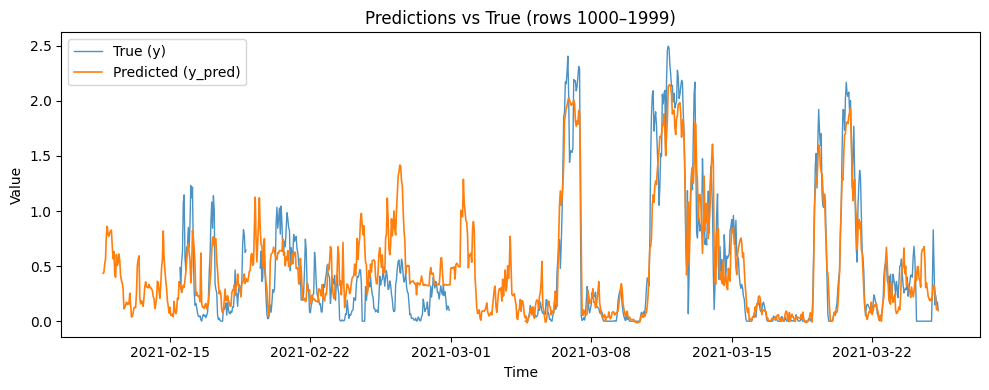

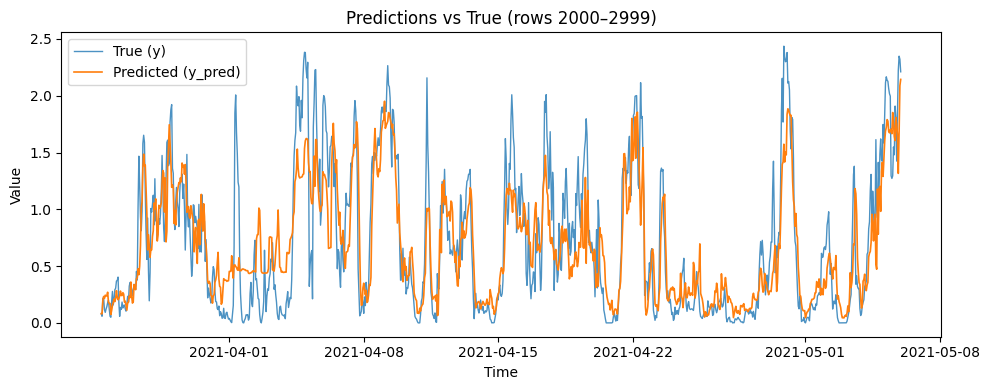

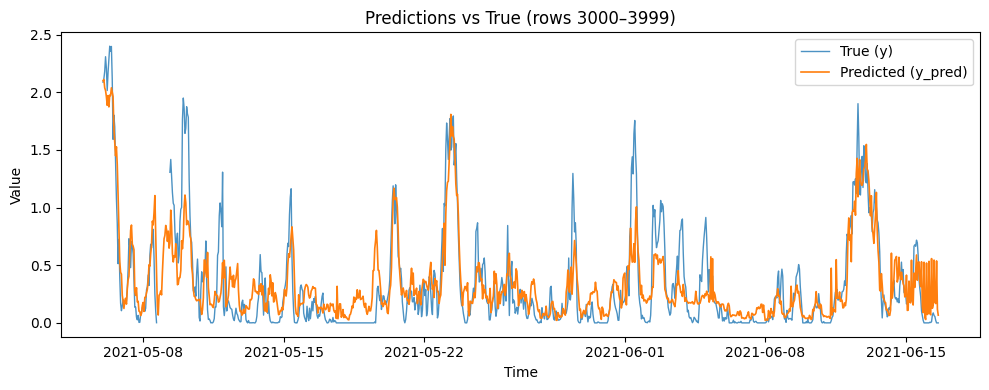

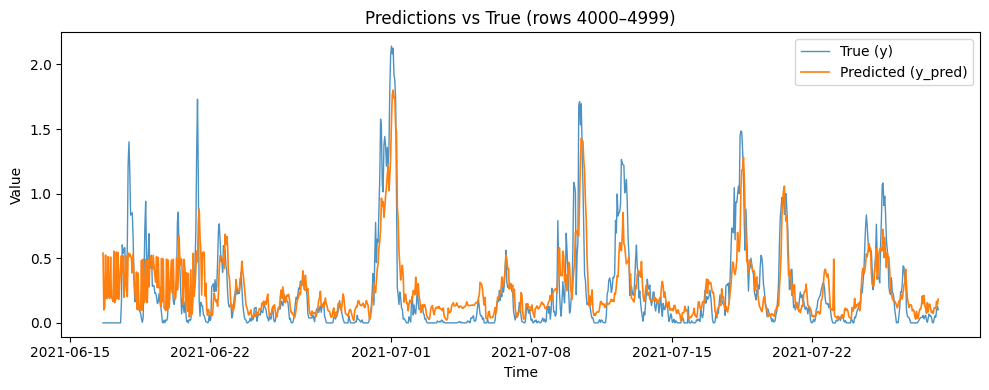

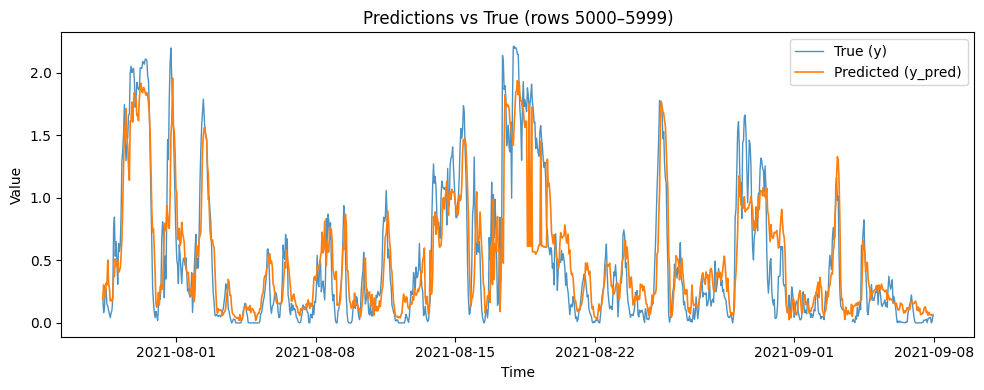

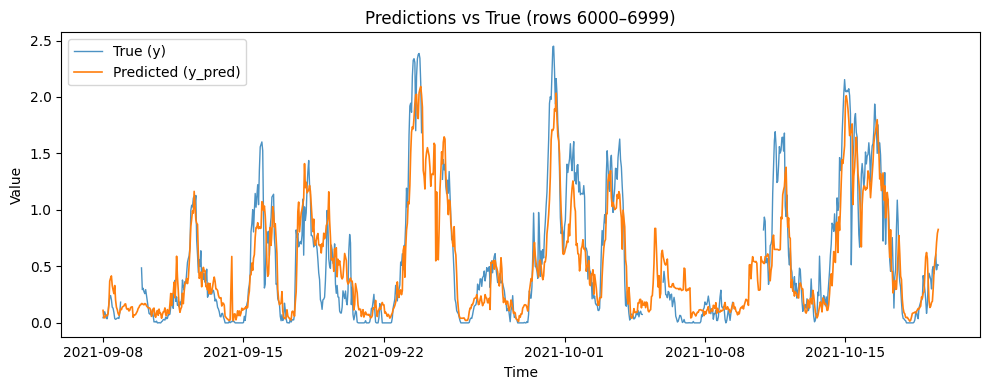

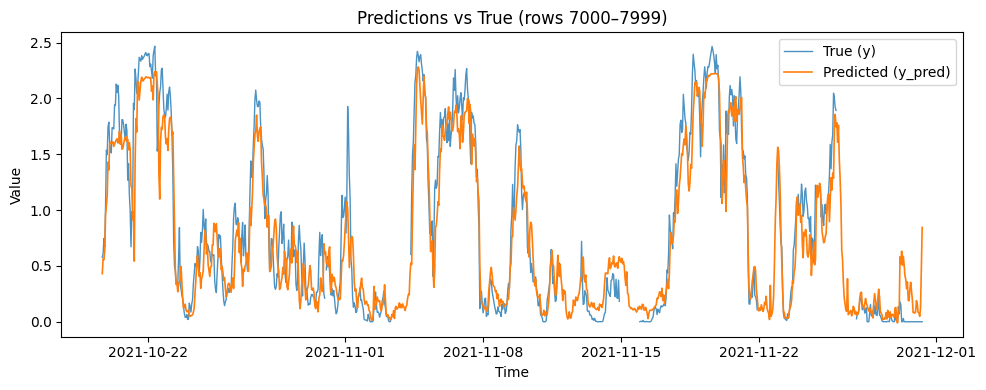

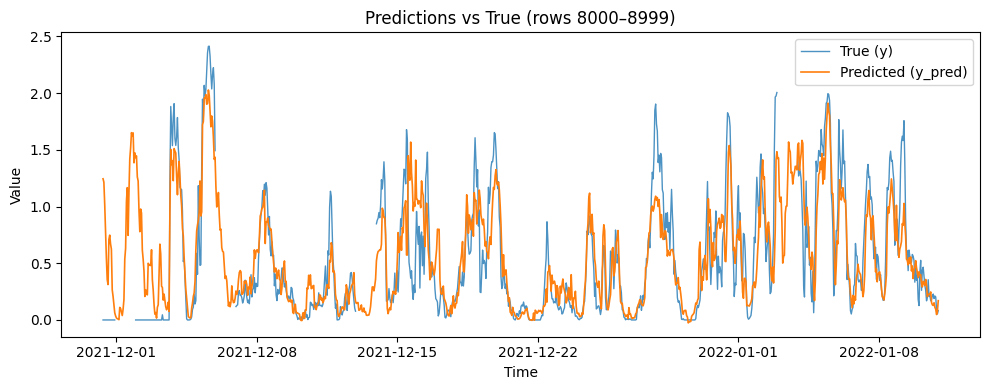

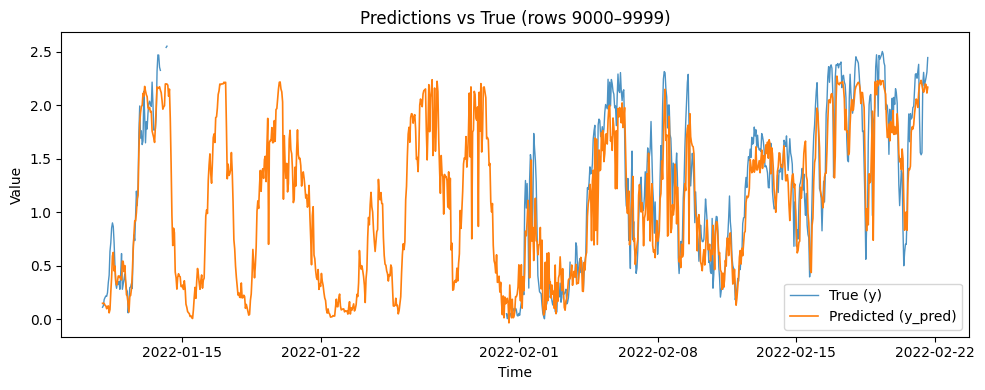

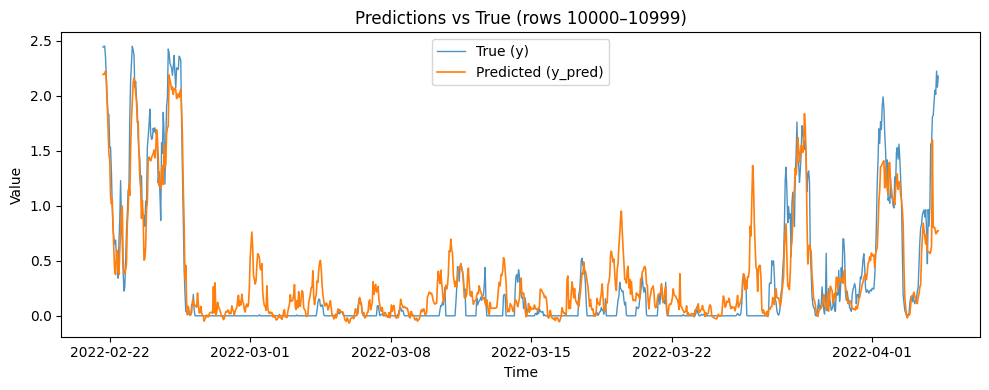

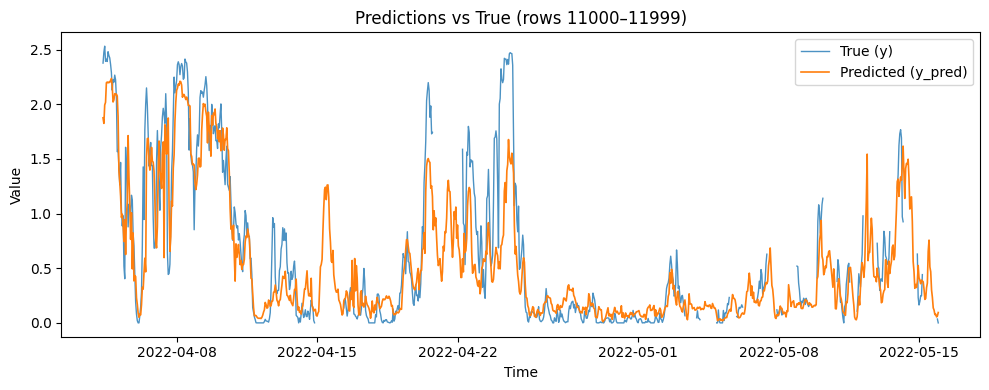

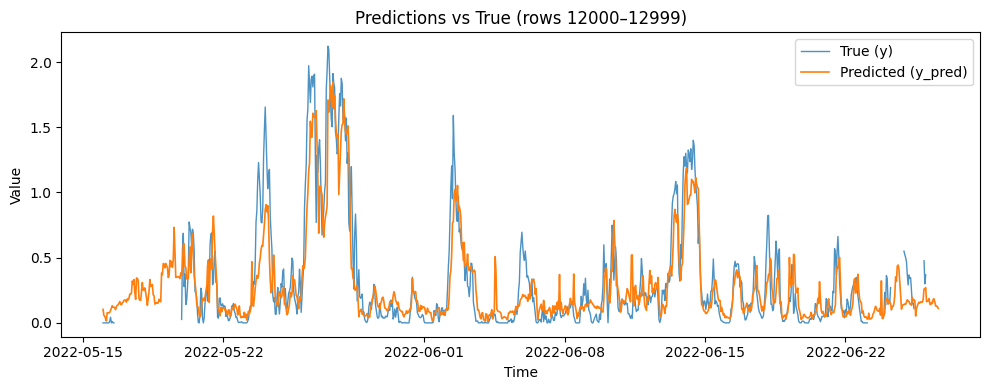

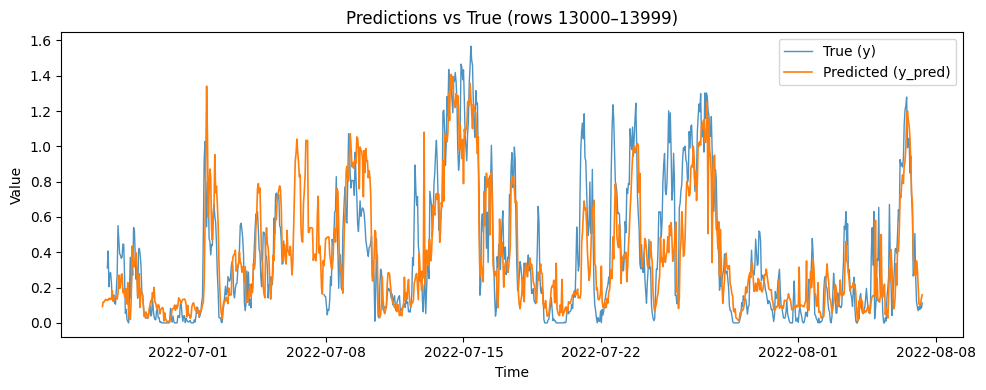

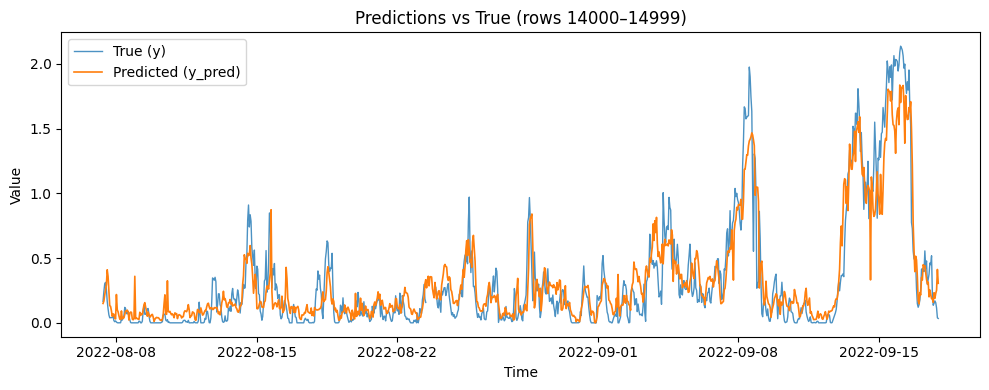

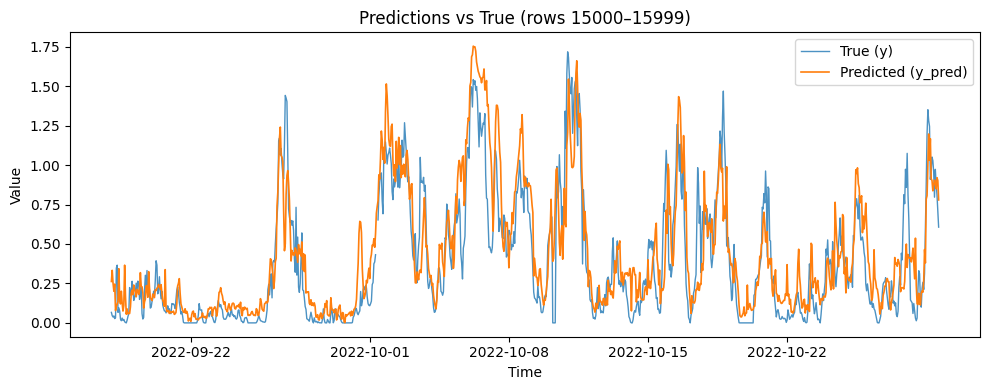

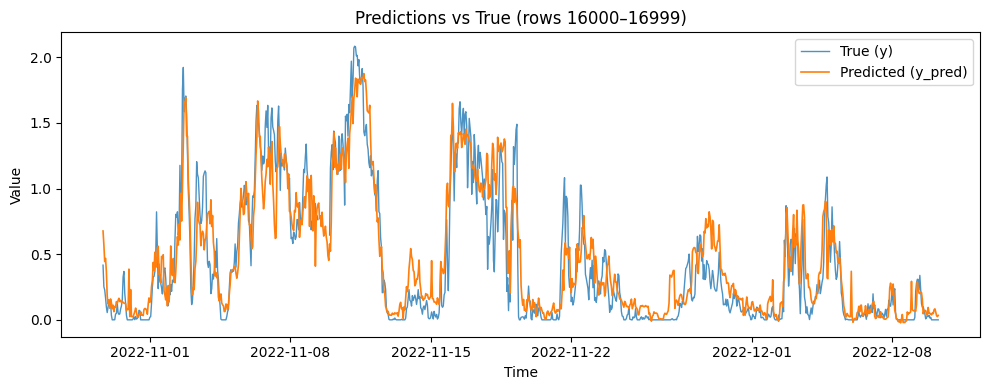

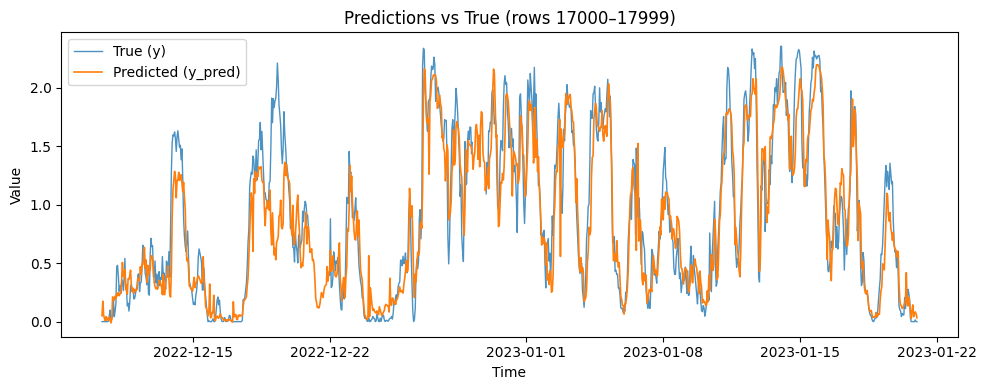

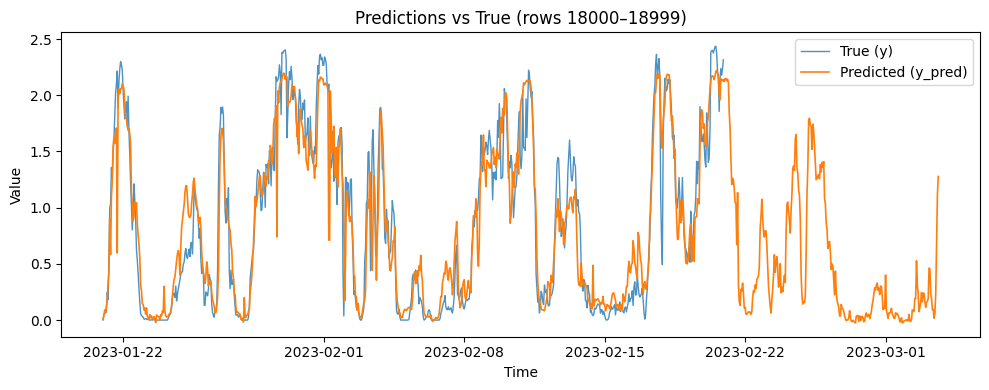

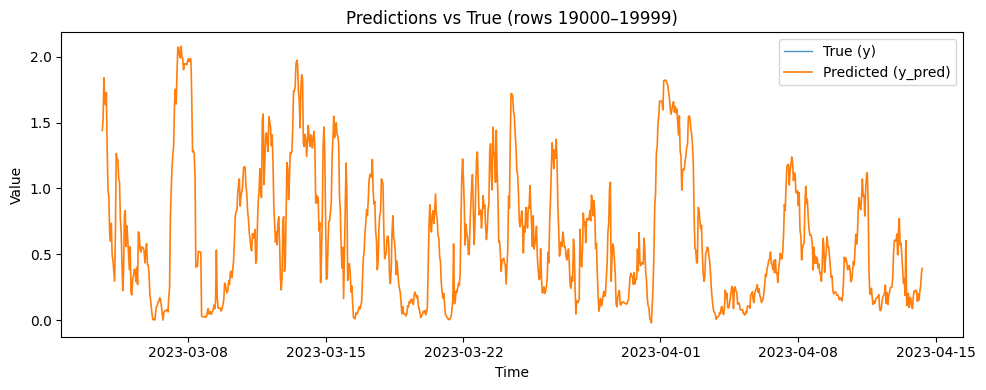

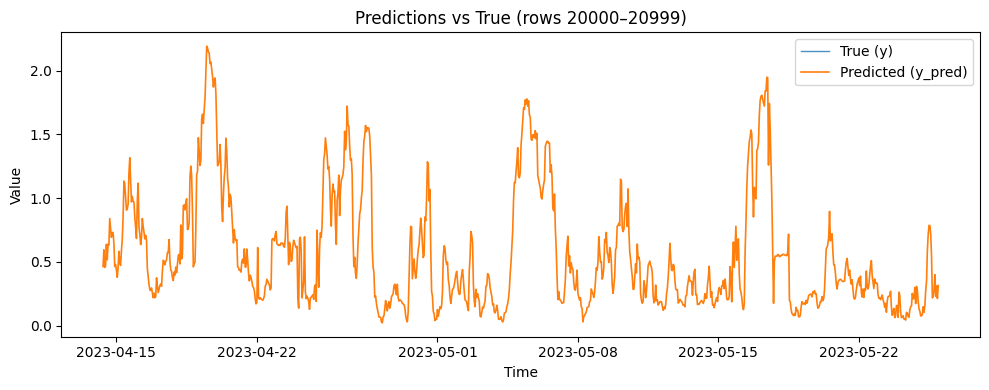

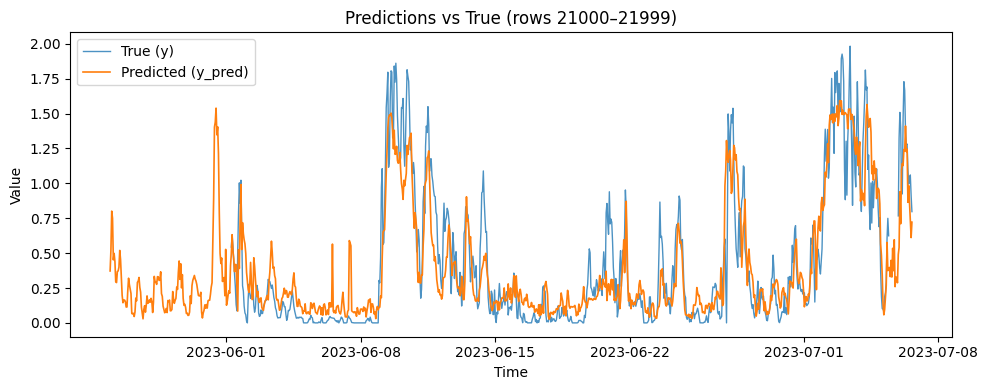

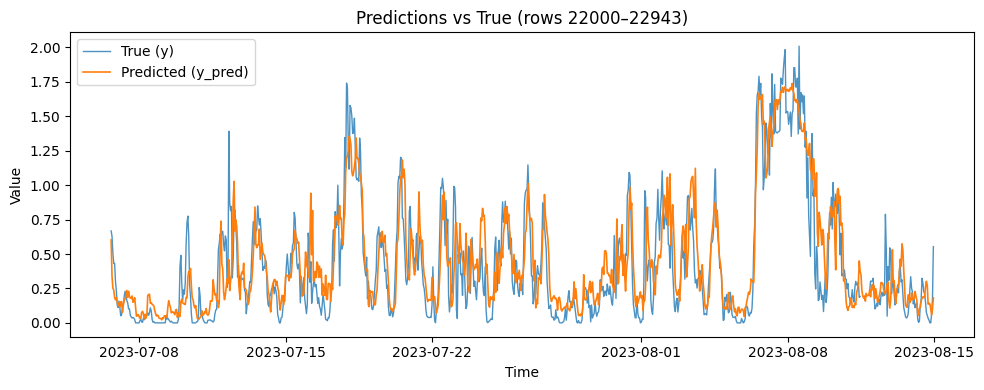

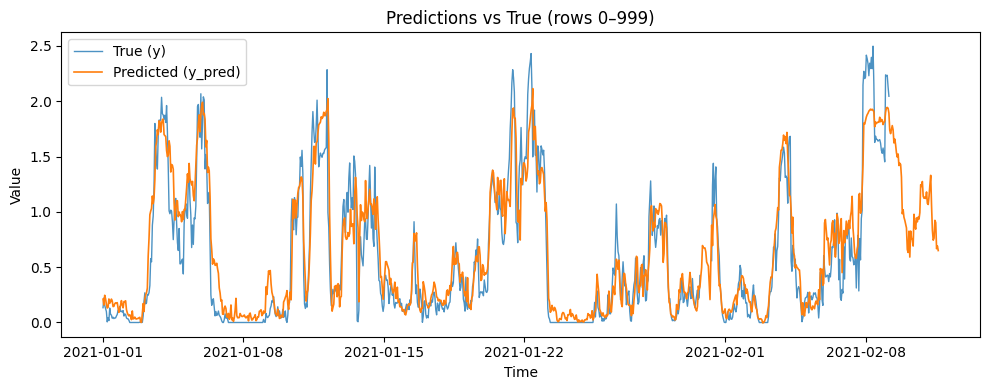

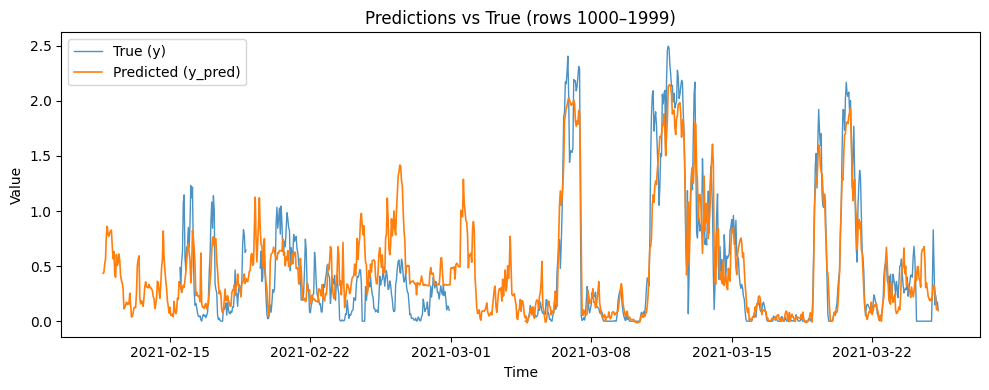

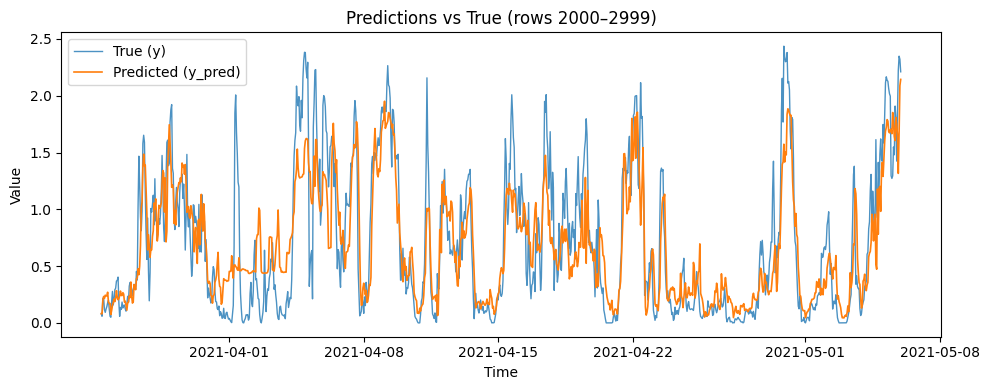

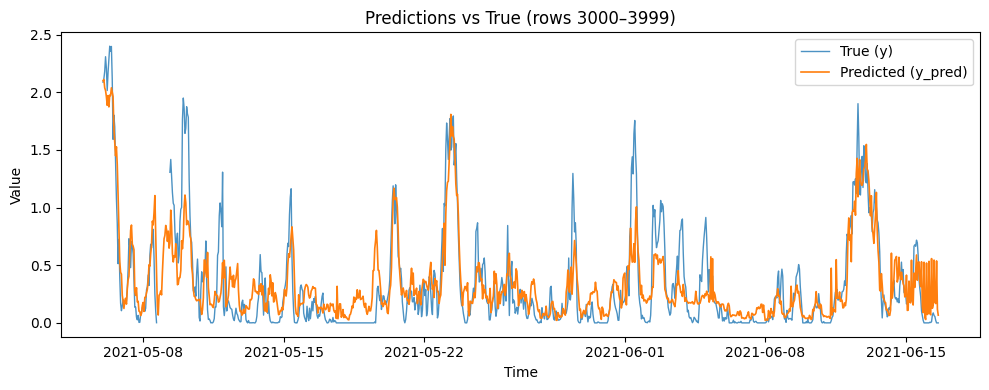

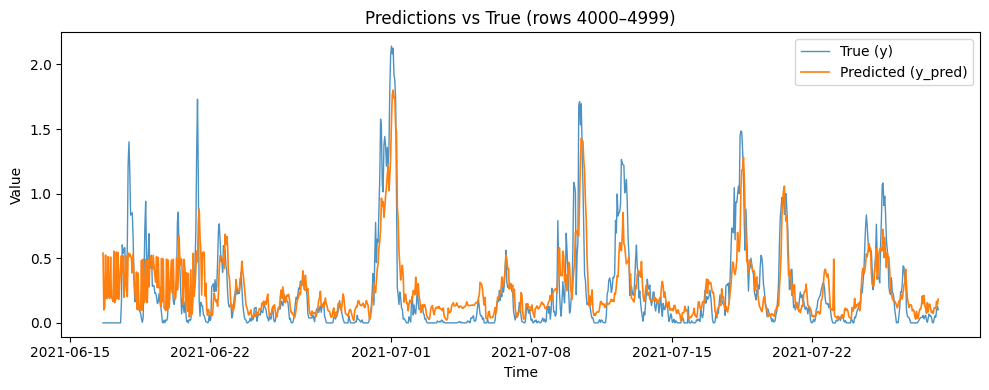

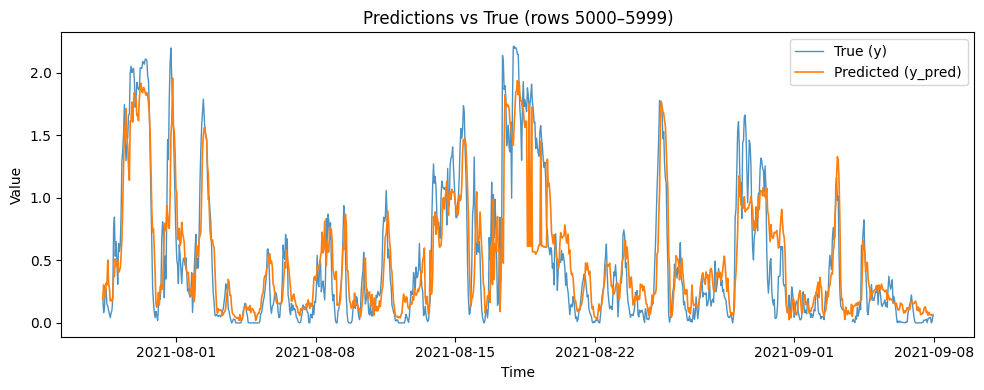

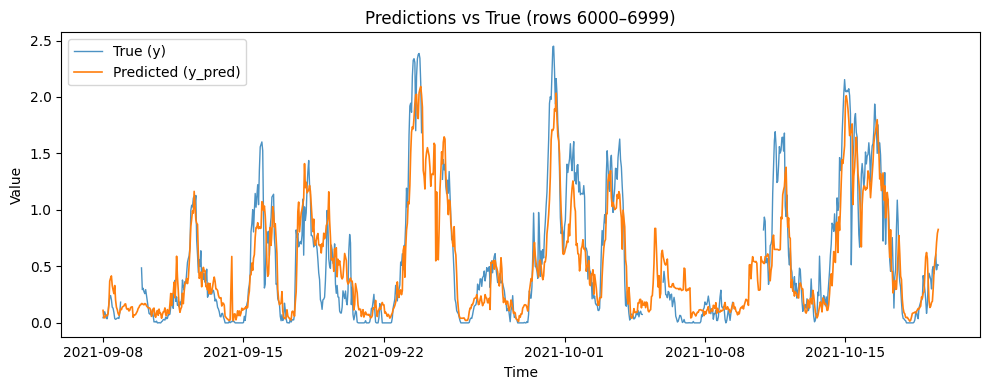

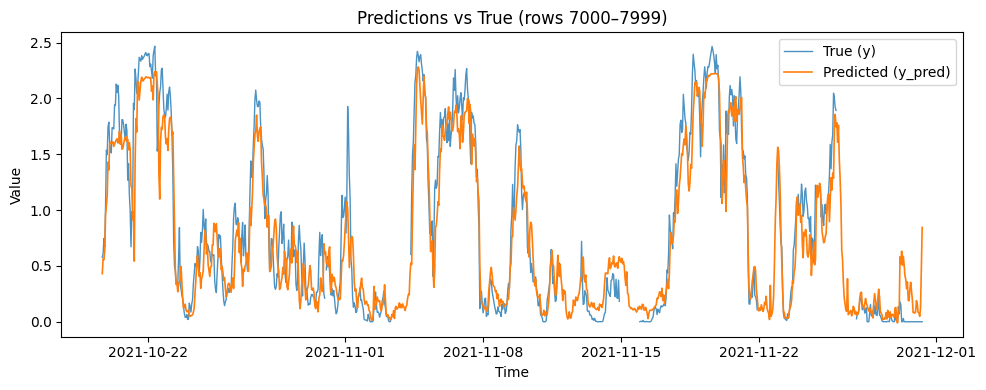

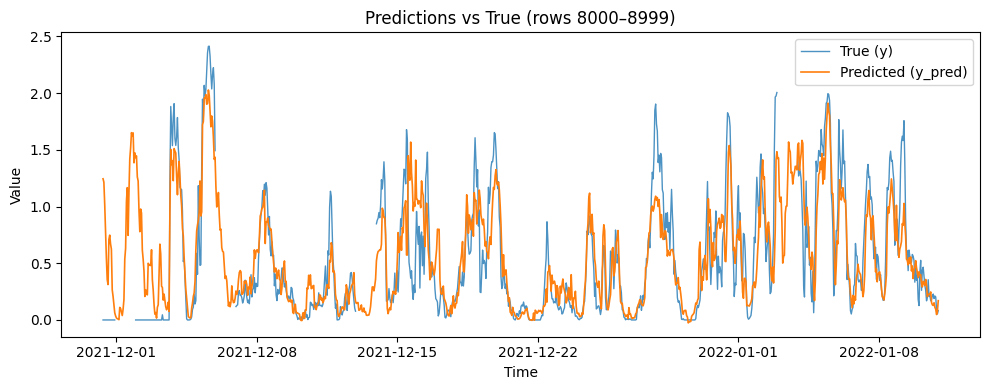

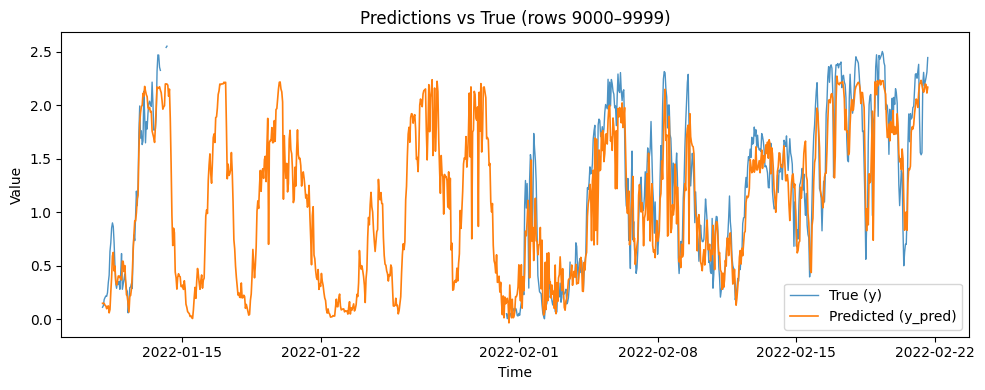

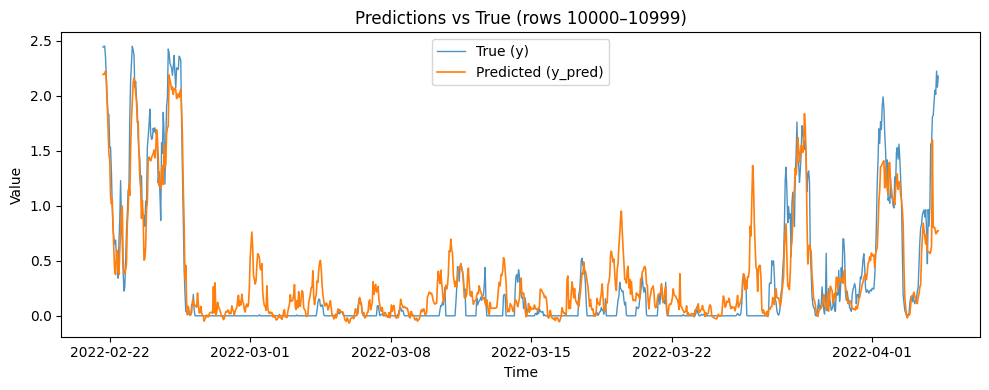

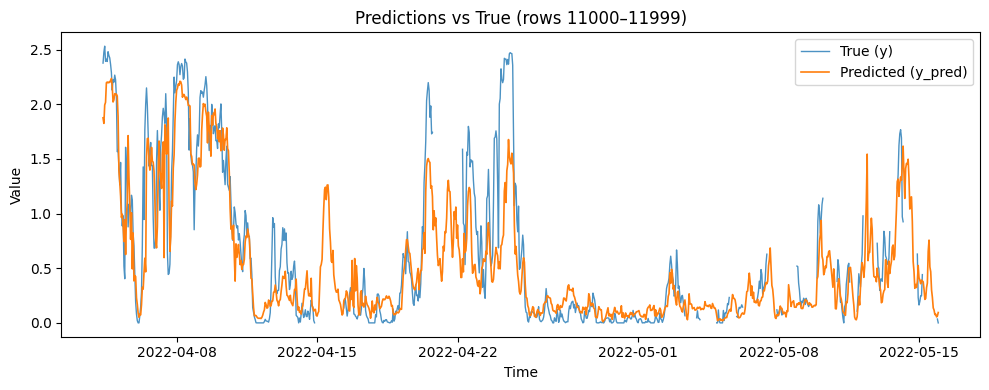

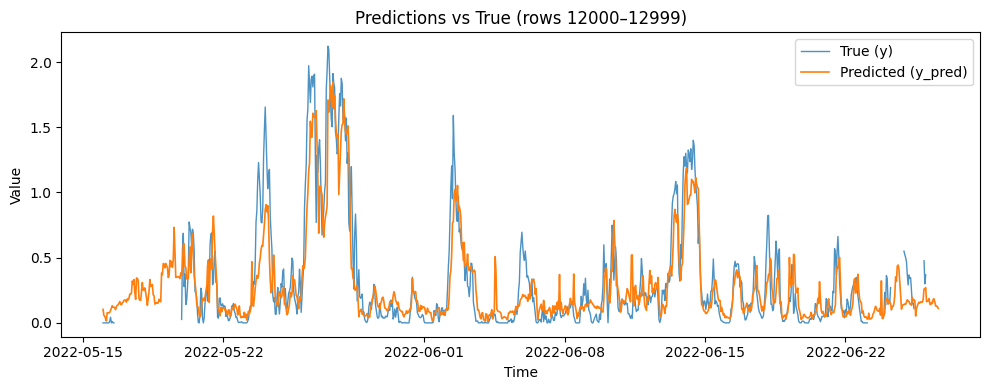

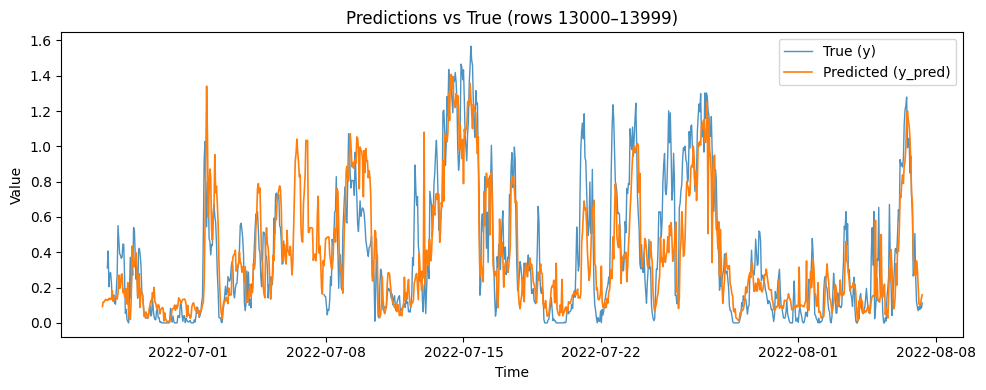

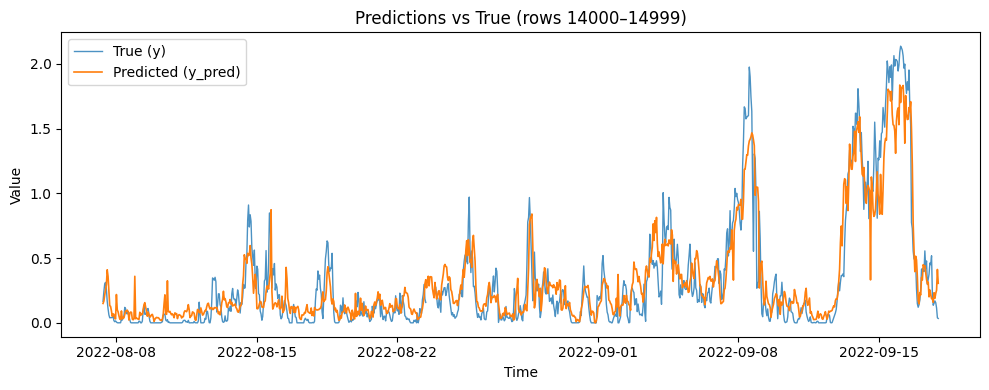

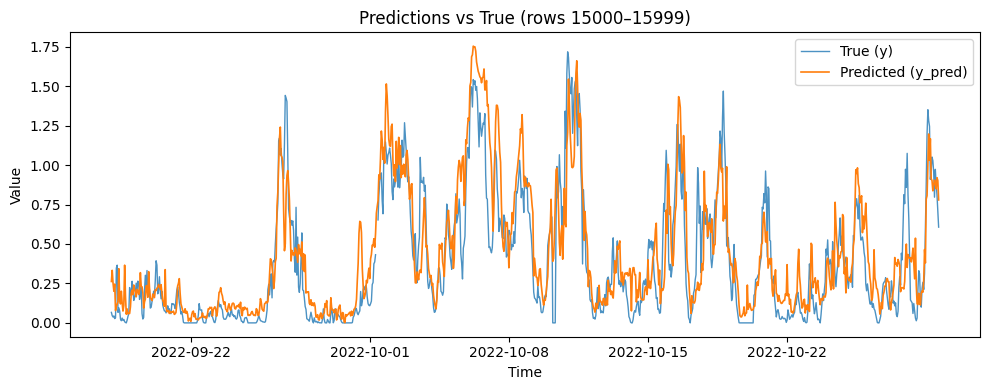

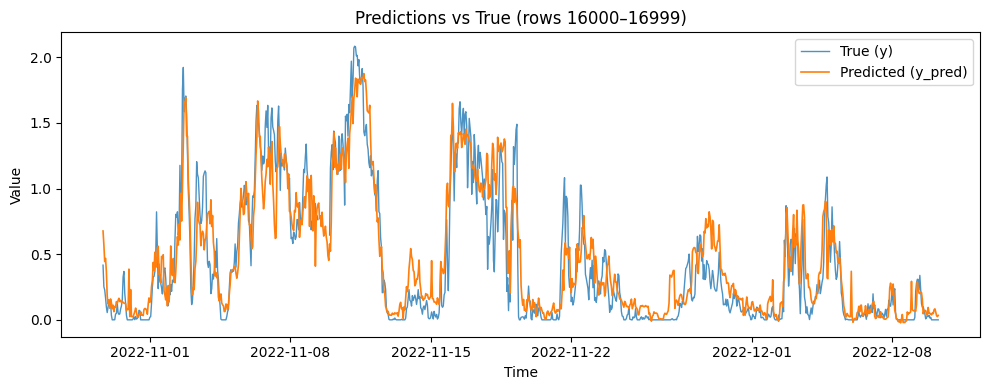

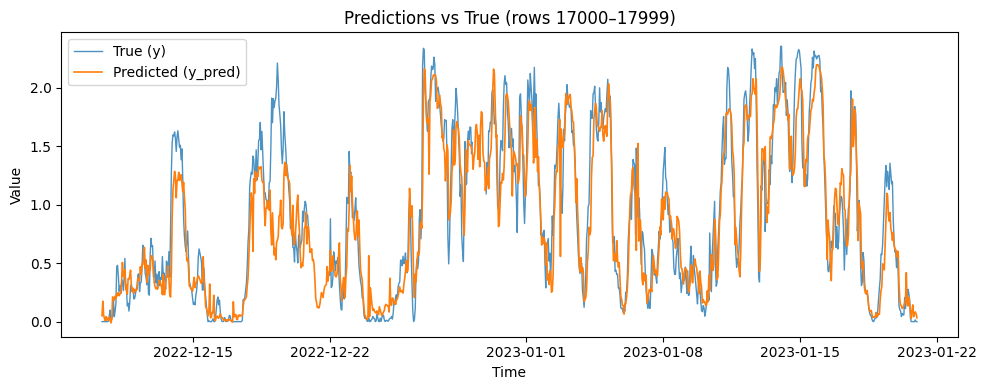

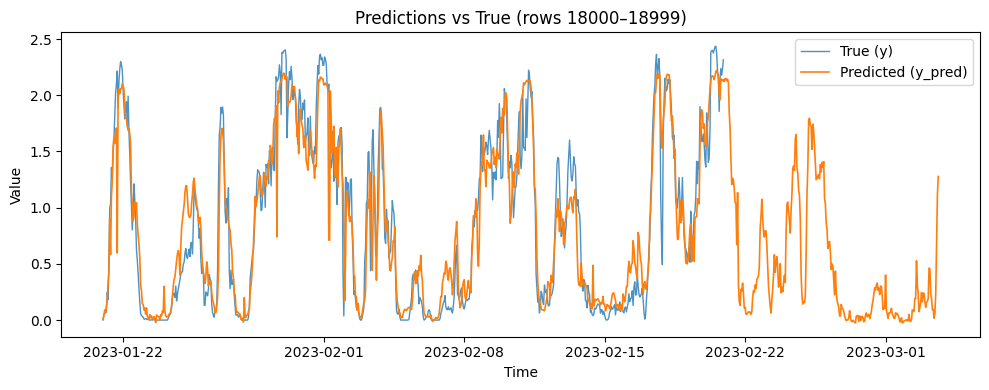

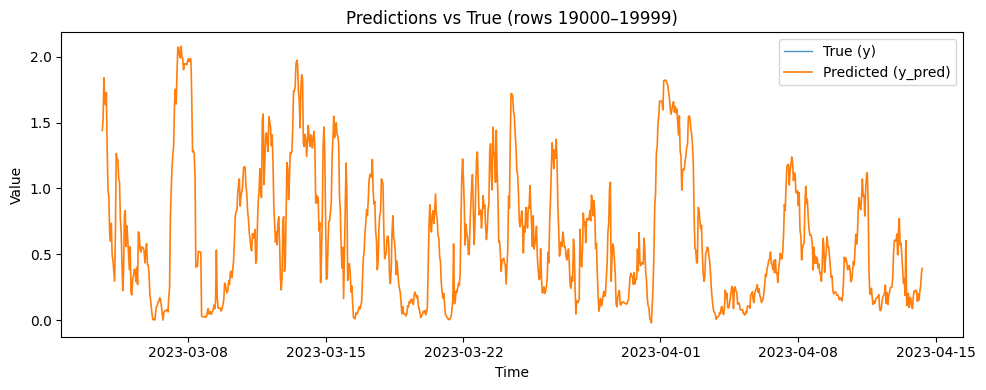

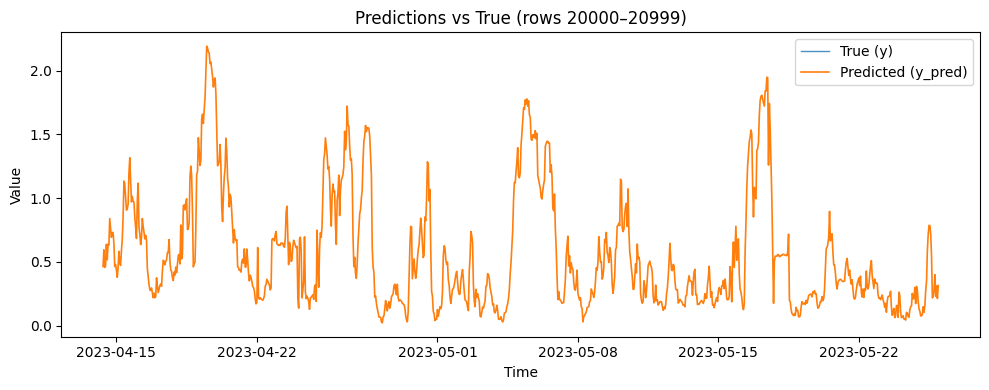

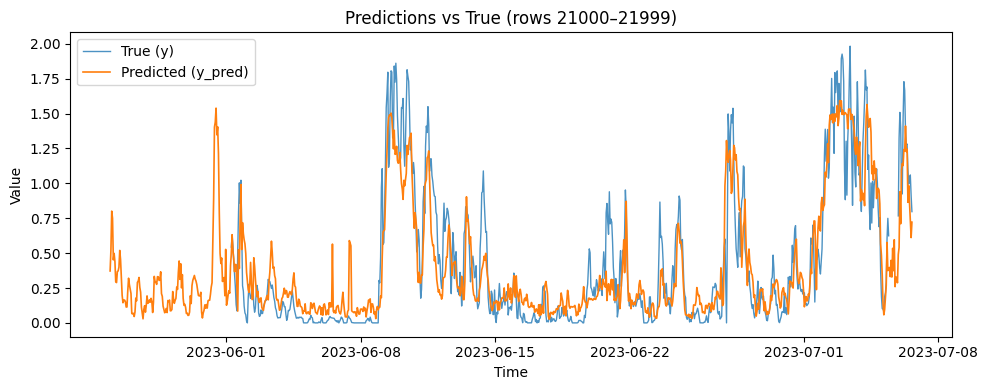

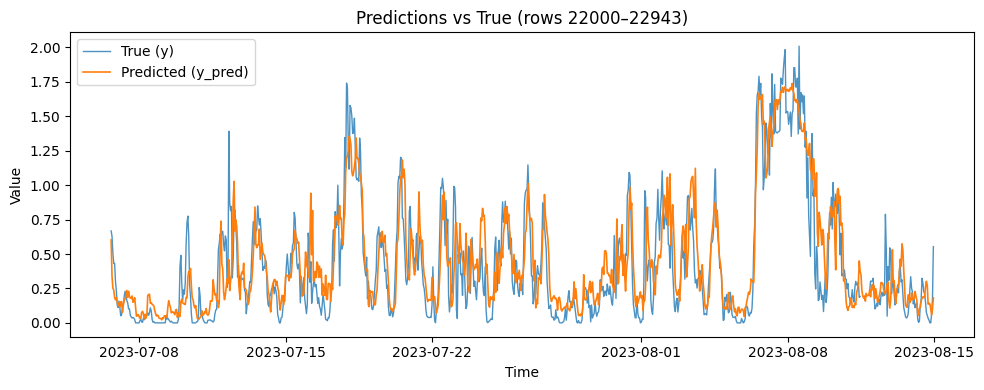

In [19]:
# 1) Predict (if not already done)
y_pred = grid_search.predict(powerforecast_x)
y_pred = pd.Series(y_pred, index=powerforecast_x.index, name="y_pred")

# 2) Align by index and (optionally) sort by time
plot_df = pd.DataFrame({"y_true": powerforecast_y, "y_pred": y_pred}).sort_index()

# 3) Plot in chunks of 1000
chunk = 1000
n = len(plot_df)

for start in range(0, n, chunk):
    end = min(start + chunk, n)
    seg = plot_df.iloc[start:end]

    # Optional: RMSE for this chunk (only where y_true is known)
    mask_known = seg["y_true"].notna()
    if mask_known.any():
        rmse_chunk = np.sqrt(mean_squared_error(seg.loc[mask_known, "y_true"],
                                               seg.loc[mask_known, "y_pred"]))

    plt.figure(figsize=(10, 4))
    plt.plot(seg.index, seg["y_true"], label="True (y)", linewidth=1.0, alpha=0.8)
    plt.plot(seg.index, seg["y_pred"], label="Predicted (y_pred)", linewidth=1.2)
    plt.title(f"Predictions vs True (rows {start}–{end-1})")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    plt.show()


# 1) Predict (if not already done)
y_pred = grid_search.predict(powerforecast_x)
y_pred = pd.Series(y_pred, index=powerforecast_x.index, name="y_pred")

# 2) Align by index and (optionally) sort by time
plot_df = pd.DataFrame({"y_true": powerforecast_y, "y_pred": y_pred}).sort_index()

# 3) Plot in chunks of 1000
chunk = 1000
n = len(plot_df)

for start in range(0, n, chunk):
    end = min(start + chunk, n)
    seg = plot_df.iloc[start:end]

    plt.figure(figsize=(10, 4))
    plt.plot(seg.index, seg["y_true"], label="True (y)", linewidth=1.0, alpha=0.8)
    plt.plot(seg.index, seg["y_pred"], label="Predicted (y_pred)", linewidth=1.2)
    plt.title(f"Predictions vs True (rows {start}–{end-1})")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    plt.show()